# Loss functions and gradients in algorithmic recourse

This is a short tutorial on gradients typically involved in optimization problems of algorithmic recourse.

In [65]:
using Zygote
using Plots

## General setup

Let $t\in\{0,1\}$ denote the target label, $f\in\{0,1\}$ the predicted label and $x'\in\mathbb{R}^D$ the vector of counterfactual features. Then the optimization problem in algorithmic recourse is generally of the following form:

$$
x' = \arg \min_{x'} \max _{\lambda} \lambda \ell(f,t,x') + h(x')
$$

where $\ell$ denotes some loss function targeting the deviation between the target label and the predicted label and $h(\cdot)$ as a complexity penality generally addressing the *realism* or *cost* of the proposed counterfactual. 

## Loss function $\ell$

Different choices for $\ell$ come to mind, each potentially leading to very different counterfactual outcomes. Typically $\ell$ is implemented with respect to the predicted *logits*: $a=\mathbf{w}^Tx$. We follow this convention here. Common choices for $\ell$ in the literature have included *Hinge* and *cross-entropy* (or *log*) loss. We shall look at these in some more details here.

### Hinge loss

With respect to the logits $a=\mathbf{w}'x$ Hinge loss can be defined as follows

$$
\ell(a,t)=(t-a)_+=\max\{0,t-a\}
$$

where $t$ is the target class in as before (we have $t\in\{0,1\}$ for a binary classification problem).

**NOTE**: Hinge loss is generally defined for the target domain $\{-1,1\}$. Therefore in our context we have $a=z \mathbf{w}'x_{\text{cf}}$ where 

$$
\begin{aligned}
z&=\begin{cases}
-1 && \text{if} && f=0 \\ f && \text{if} && f=1
\end{cases}
\end{aligned}
$$

The first-order derivative of Hinge loss is simply

$$
\begin{aligned}
\ell'(a,t)&=\begin{cases}
-1 && \text{if} && a<1 \\ 0 && \text{otherwise.} 
\end{cases}
\end{aligned}
$$

In practice gradients are commonly computed through autodifferentiation. In this tutorial we use the Zygote.jl package which is at the core of [Flux.jl](https://fluxml.ai/Flux.jl/stable/models/basics/), the main deep learning package for Julia.

In [66]:
hinge(a,t) = max(0,t-a)

hinge (generic function with 1 method)

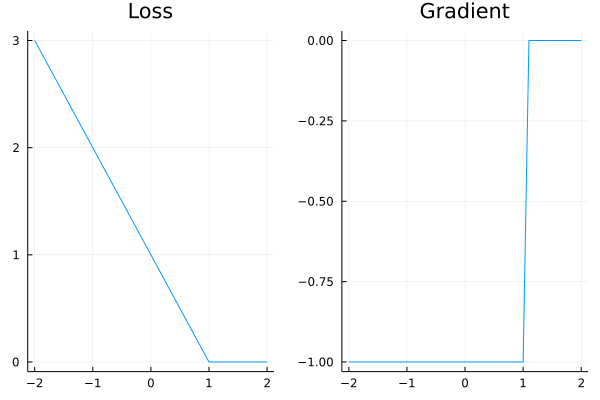

In [72]:

a = -2:0.1:2
p1 = plot(a, [hinge(a,1) for a=a], title="Loss")
p2 = plot(a, [gradient(hinge,a,1)[1] for a=a], title="Gradient")
plot(p1, p2, layout = (1, 2), legend = false)

### Cross-entropy loss (binary)

Binary cross-entropy loss or log loss is typically defined as follows:

$$
\begin{aligned}
&& \ell(a,t)&=- \left( t \cdot \log(\sigma(a)) + (1-t) \cdot \log (1-\sigma(a)) \right) \\
\end{aligned}
$$

where $\sigma(a)$ is the logit function.

Once again for the purpose of counter factual search we are interested in the first-order derivative with respect to our feature vector $x'$. You can verify that the partial derivative with respect to feature $x'_d$ is as follows:

$$
\begin{aligned}
&& \frac{\partial \ell(a,t)}{\partial x'_d}&= (\sigma(a) - t) w_d \\
\end{aligned}
$$

The gradient just corresponds to the stacked vector of partial derivatives:

$$
\begin{aligned}
&& \nabla_{x'} \ell(a,t)&= (\sigma(a) - t) \mathbf{w} \\
\end{aligned}
$$

As before implementation below is done through autodifferentiation.

In [73]:
# logit function:
function 𝛔(a)
    trunc = 8.0 # truncation to avoid numerical over/underflow
    a = clamp.(a,-trunc,trunc)
    p = exp.(a)
    p = p ./ (1 .+ p)
    return p
end

# Binary crossentropy:
crossentropy(y, t) = - (t * log(𝛔(y)) + (1-t) * log(1-𝛔(y)))

crossentropy (generic function with 1 method)

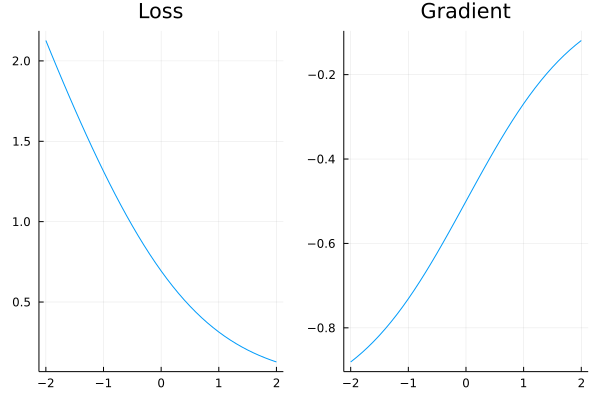

In [75]:
p1 = plot(a, [crossentropy(a,1) for a=a], title="Loss")
p2 = plot(a, [gradient(crossentropy,a,1)[1] for a=a], title="Gradient")
plot(p1, p2, layout = (1, 2), legend = false)

In [76]:
# Cross-entropy:
function gradient_man(x,w,y)
    𝐠 = (𝛔(w'x) - y) .* w
    return 𝐠
end;

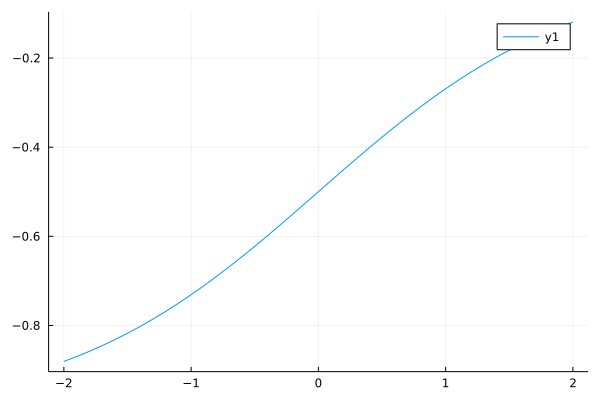

In [77]:
p3 = plot(a, [gradient_man(a,1,1) for a=a])

### Mean squared error

